# Model Evaluation
### Evaluate Model, Post Processing and Submission file preperation

In [5]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.5.6
Number of GPUs Available: 0


In [6]:
import numpy as np
import pandas as pd
import os

import keras
import random
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from util.mask_to_submission import masks_to_submission
import util.metrics as metrics
import util.utility as util
import util.post_processing as pp

## Install the following packages
import imageio
import natsort
import logging

## Constants

In [7]:
# Name of the current model
MODEL_NAME = 'final_model'
IMG_WIDTH = 608
IMG_HEIGHT = 608
BATCH_SIZE = 2          # 8 on Leonhard
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Images
Load a validation set and test images

In [8]:
logging.info('Loading training and test images')
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/normal/"
rotated_test_image_dir = "test_images/rotated/"

files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)
files_image_validation = files_image[-10:]

files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)
files_label_validation = files_label[-10:]

files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)

# Load Images and labels
validation_image = util.load_images(training_image_dir, files_image_validation, "RGB")
validation_label = util.load_images(training_label_dir, files_label_validation, "L")

test_image = pp.prepare_test_images(len(files_test), test_image_dir, files_test, rotated_test_image_dir)

print("TRAINING:")
print(validation_image.shape)
print(validation_label.shape)
print("TEST:")
print(test_image.shape)

Loading 10 images
Loading 10 images
Rotating 94 test images
TRAINING:
(10, 400, 400, 3)
(10, 400, 400)
TEST:
(752, 608, 608, 3)


## Preprocess Images
- validation images have size 400x400 and test images have size 608x608. So we
  need to pad validation images to same size, for that we use mirror padding for now.
- Rescale images

(10, 608, 608, 3)
(10, 608, 608, 1)
(752, 608, 608, 3)


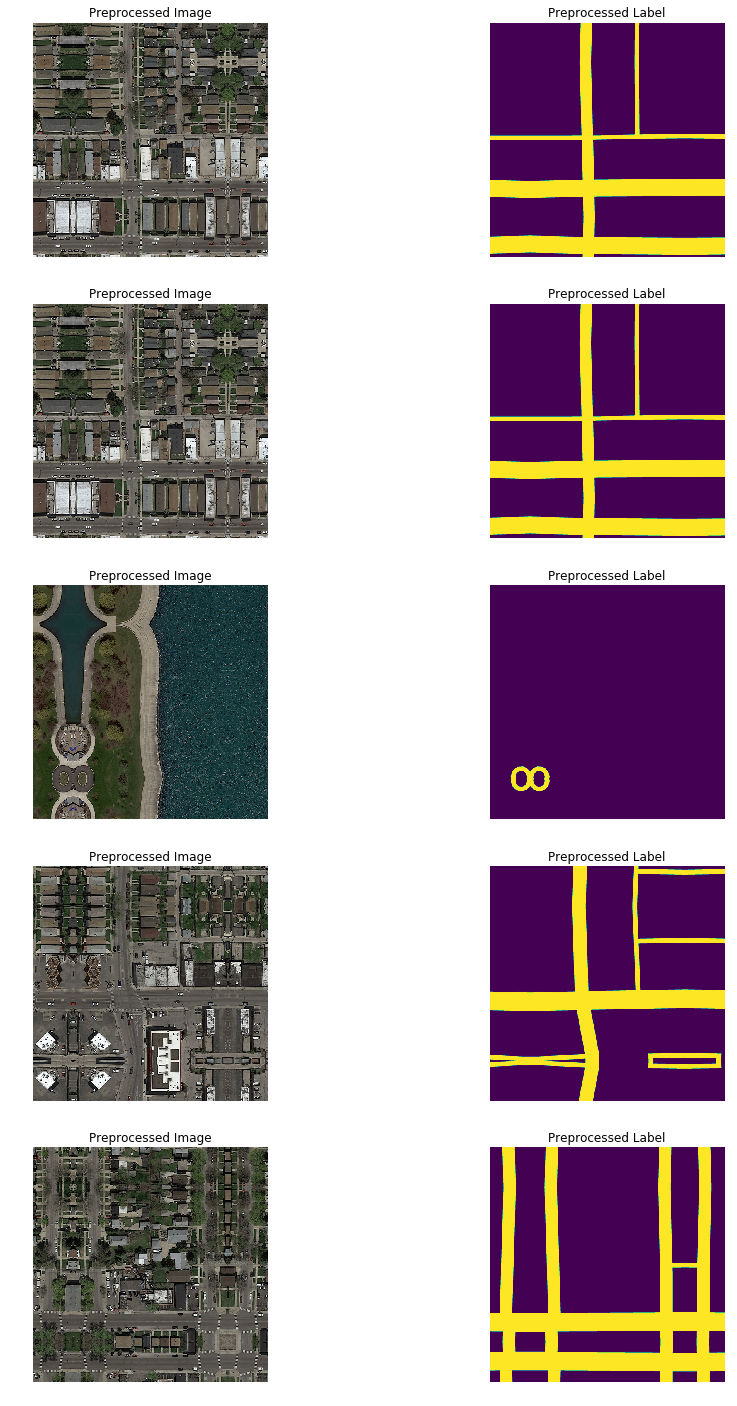

In [9]:
# Mirror padd all validation images to get same size as test images
validation_image = util.padd_images(validation_image, 608, 608).astype(np.uint8)
validation_label = util.padd_images(validation_label, 608, 608).astype(np.uint8)
validation_label = np.expand_dims(validation_label, -1)

# Rescale validation images/labels and test images because generator will do the same with training data
validation_image = validation_image.astype(np.float32)/255.0
validation_label = validation_label.astype(np.float32)/255.0
test_image = test_image.astype(np.float32)/255.0
logging.info('Finished Preprocessing!')

print(validation_image.shape)
print(validation_label.shape)
print(test_image.shape)

# Plot random Sample of images
n = validation_image.shape[0]
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*2, 2):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 2, i)
  plt.imshow(validation_image[index])
  plt.title("Preprocessed Image")
  plt.axis('off')

  f.add_subplot(num_samples, 2, i+1)
  plt.imshow(np.squeeze(validation_label[index]))
  plt.title("Preprocessed Label")
  plt.axis('off')

plt.show()

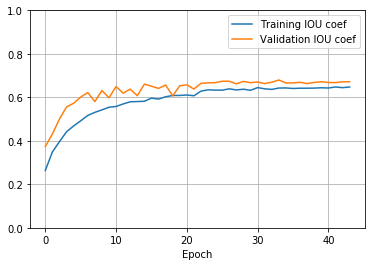

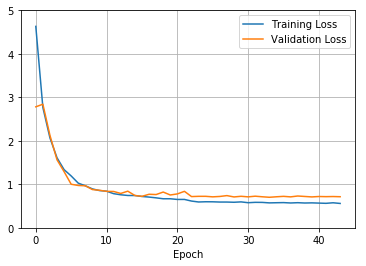

In [10]:
# Show a training report (only works if logfile is imported from cluster into /Logs/)
training_info = pd.read_csv('./Logs/{}_log.csv'.format(MODEL_NAME), header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.grid(True)

plt.show()

## Model Evaluation
Import newest model from Cluster to \Models\ !

In [11]:
# Kaggle scores on validation images (mean score per image and overall mean score)
model = load_model("./Models/{}.h5".format(MODEL_NAME), custom_objects={'combined_loss': metrics.combined_loss, 'iou_coef': metrics.iou_coef})
y_pred = model.predict(validation_image, batch_size=4, verbose=1)
scores = util.validate_kaggle_score(validation_label, y_pred)
print(sum(scores)/len(scores))

3/3 [==============================] - 5s 2s/step
0.8557783246095811


In [12]:
model = load_model("./Models/{}.h5".format(MODEL_NAME), custom_objects={'combined_loss': metrics.combined_loss, 'iou_coef': metrics.iou_coef})
predictions = model.predict(test_image, batch_size=4, verbose=1)

188/188 [==============================] - 751s 4s/step


In [13]:
# Post Processing
MODE = 'only90_max'
RESULT_DIR = './Results/Prediction_Images/{}/'.format(MODEL_NAME)

# combine all 8 predicted Images with MODE and save to RESULT_DIR
pp.combine_and_save(MODE, RESULT_DIR, predictions, files_test)

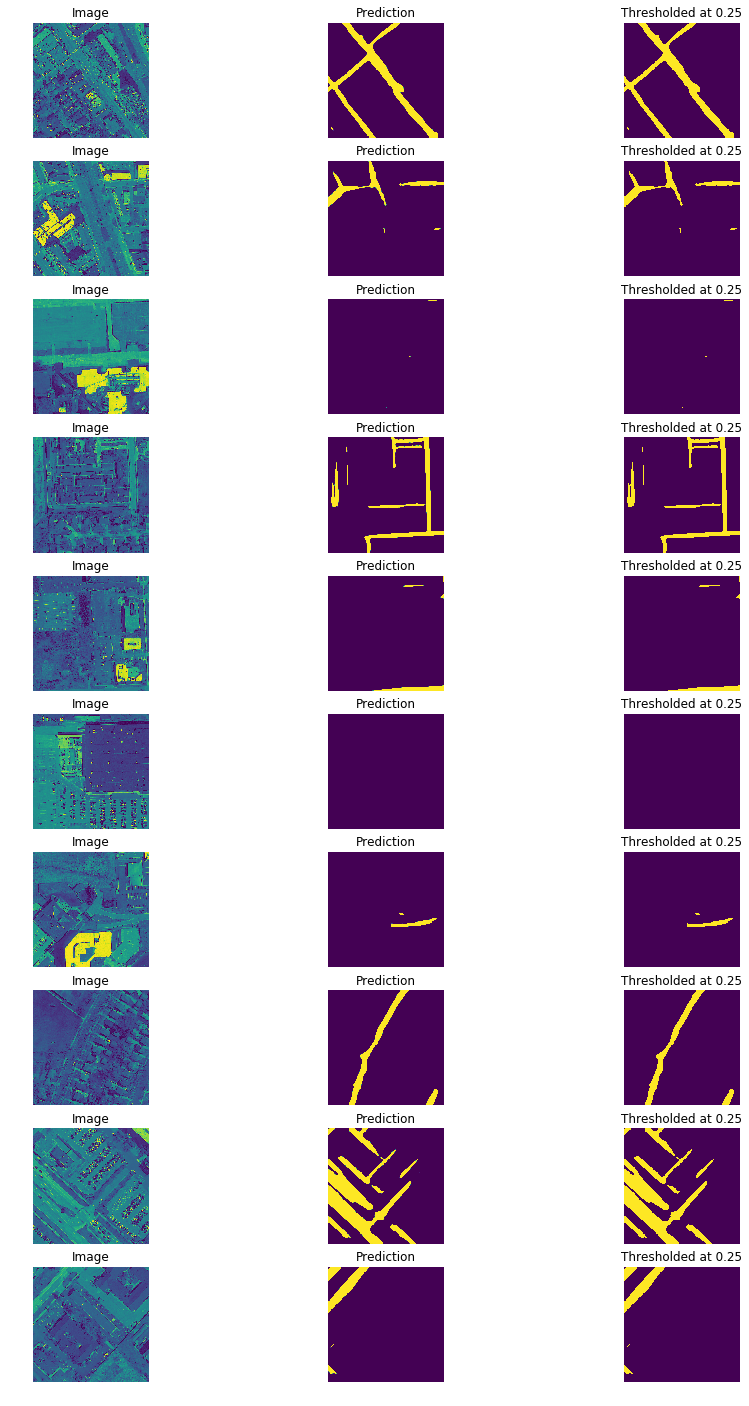

In [14]:
# Plot Predictions
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)
index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File

In [15]:
result_dir = './Results/Prediction_Images/{}/'.format(MODEL_NAME)
submission_filename = './Results/Submissions/{}.csv'.format(MODEL_NAME)
util.create_submission(predictions, result_dir, submission_filename, files_test)

./Results/Prediction_Images/final_model/test_10.pngtest
./Results/Prediction_Images/final_model/test_105.pngtest
./Results/Prediction_Images/final_model/test_106.pngtest
./Results/Prediction_Images/final_model/test_107.pngtest
./Results/Prediction_Images/final_model/test_108.pngtest
./Results/Prediction_Images/final_model/test_11.pngtest
./Results/Prediction_Images/final_model/test_115.pngtest
./Results/Prediction_Images/final_model/test_116.pngtest
./Results/Prediction_Images/final_model/test_12.pngtest
./Results/Prediction_Images/final_model/test_121.pngtest
./Results/Prediction_Images/final_model/test_122.pngtest
./Results/Prediction_Images/final_model/test_123.pngtest
./Results/Prediction_Images/final_model/test_124.pngtest
./Results/Prediction_Images/final_model/test_128.pngtest
./Results/Prediction_Images/final_model/test_129.pngtest
./Results/Prediction_Images/final_model/test_130.pngtest
./Results/Prediction_Images/final_model/test_131.pngtest
./Results/Prediction_Images/final_